In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

In [4]:

train_df = pd.read_csv('UNSW_NB15_training-set.csv')
test_df = pd.read_csv('UNSW_NB15_testing-set.csv')

In [5]:

print("Training Data Summary:")
print(train_df.describe())
print("\nTest Data Summary:")
print(test_df.describe())

Training Data Summary:
                  id            dur          spkts          dpkts  \
count  175341.000000  175341.000000  175341.000000  175341.000000   
mean    87671.000000       1.359389      20.298664      18.969591   
std     50616.731112       6.480249     136.887597     110.258271   
min         1.000000       0.000000       1.000000       0.000000   
25%     43836.000000       0.000008       2.000000       0.000000   
50%     87671.000000       0.001582       2.000000       2.000000   
75%    131506.000000       0.668069      12.000000      10.000000   
max    175341.000000      59.999989    9616.000000   10974.000000   

             sbytes        dbytes          rate           sttl           dttl  \
count  1.753410e+05  1.753410e+05  1.753410e+05  175341.000000  175341.000000   
mean   8.844844e+03  1.492892e+04  9.540619e+04     179.546997      79.609567   
std    1.747656e+05  1.436542e+05  1.654010e+05     102.940011     110.506863   
min    2.800000e+01  0.000000e+

In [6]:

print("\nMissing Values in Training Data:")
print(train_df.isnull().sum().sort_values(ascending=False))
print("\nMissing Values in Test Data:")
print(test_df.isnull().sum().sort_values(ascending=False))


Missing Values in Training Data:
id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0


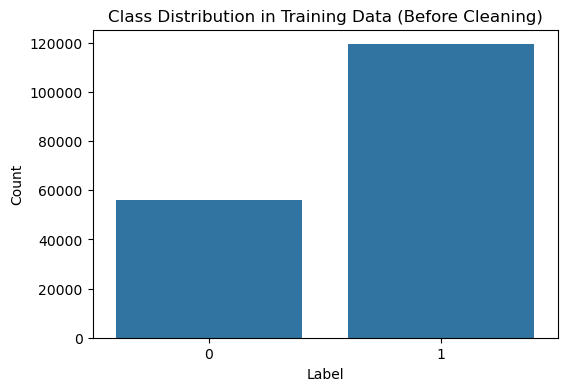

Class distribution in train_df['label']:
label
1    119341
0     56000
Name: count, dtype: int64


In [7]:
# explore label
plt.figure(figsize=(6, 4))
sns.countplot(x=train_df['label'])
plt.title('Class Distribution in Training Data (Before Cleaning)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
print("Class distribution in train_df['label']:")
print(train_df['label'].value_counts(dropna=False))

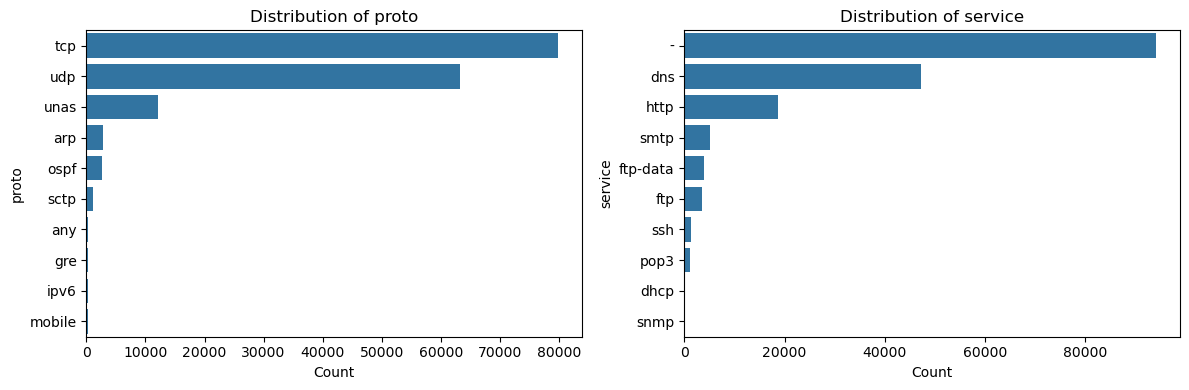

In [8]:
#explore cat coulmn
categorical_cols = ['proto', 'service']
plt.figure(figsize=(12, 4))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 2, i)
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index[:10])
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [10]:
#preprocessing
train_df = train_df.drop(['id', 'attack_cat'], axis=1, errors='ignore')
test_df = test_df.drop(['id', 'attack_cat'], axis=1, errors='ignore')

In [ ]:
#to loss time 10%
train_sample = train_df.sample(frac=0.1, random_state=42)
X = train_sample.drop('label', axis=1)
y = train_sample['label']
X_test_final = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
# shape of data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print('Training Data Shape:', X_train.shape)
print('Validation Data Shape:', X_val.shape)
print('Test Data Shape:', X_test_final.shape)

Training Data Shape: (14027, 42)
Validation Data Shape: (3507, 42)
Test Data Shape: (82332, 42)


In [ ]:
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = ['proto', 'service']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ])

In [ ]:
# transform data
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test_final)

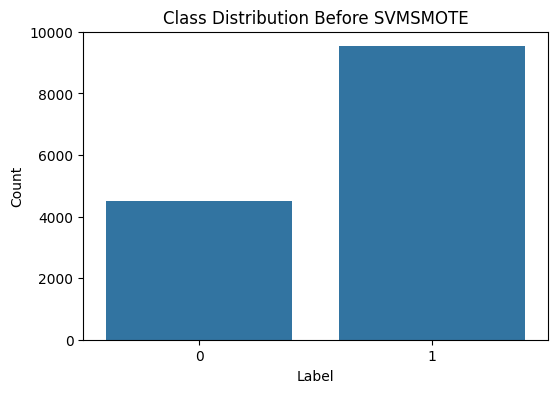

In [ ]:
# before SVMSMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Class Distribution Before SVMSMOTE')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
# SVMSMOTE
smote = SVMSMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

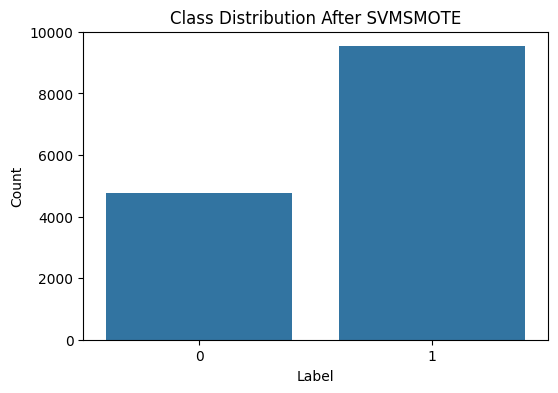

Class distribution before SVMSMOTE: label
1    9528
0    4499
Name: count, dtype: int64
Class distribution after SVMSMOTE: label
1    9528
0    4764
Name: count, dtype: int64


In [ ]:
# After SVMSMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_smote)
plt.title('Class Distribution After SVMSMOTE')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
print('Class distribution before SVMSMOTE:', y_train.value_counts())
print('Class distribution after SVMSMOTE:', pd.Series(y_train_smote).value_counts())

In [ ]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=30, max_depth=5, n_jobs=-1, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=30, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=42)
}

In [ ]:
# train
results = {}
roc_data = {}
best_accuracy = 0
best_model_name = None
final_clf = None

for model_name, model in models.items():
    print(f'\nTraining {model_name}...')
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_transformed)
    y_prob = model.predict_proba(X_test_transformed)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = {
        'accuracy': accuracy,
        'report': classification_report(y_test, y_pred, output_dict=True)
    }
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_data[model_name] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}
    print(f'\n{model_name} Accuracy:', accuracy)
    print(f'{model_name} Classification Report:\n', classification_report(y_test, y_pred))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name
        final_clf = model
print(f'\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.2f}')


Training Logistic Regression...

Logistic Regression Accuracy: 0.8139848418597873
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.64      0.76     37000
           1       0.76      0.96      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.84      0.80      0.80     82332
weighted avg       0.84      0.81      0.81     82332


Training Random Forest...

Random Forest Accuracy: 0.8088228149443716
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.73     37000
           1       0.74      1.00      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.87      0.79      0.79     82332
weighted avg       0.86      0.81      0.80     82332


Training KNN...

KNN Accuracy: 0.8452727979400476
KNN Classification Report:
               precision    reca

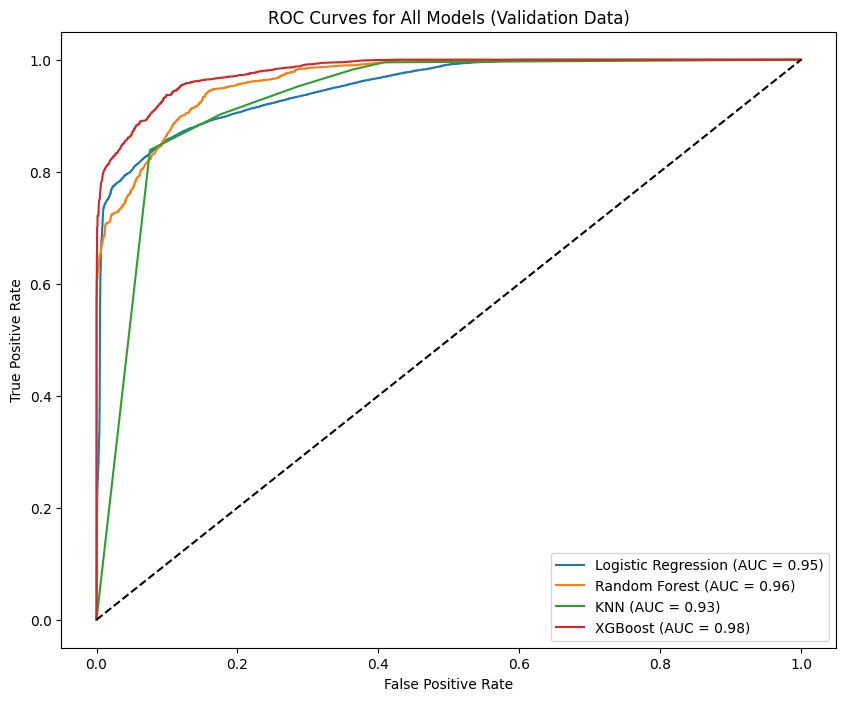

In [ ]:
# ROC
plt.figure(figsize=(10, 8))
for model_name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], label=f'{model_name} (AUC = {data["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models (Validation Data)')
plt.legend(loc='best')
plt.show()

In [ ]:

print(f'\nRetraining {best_model_name} on full training data...')
X_full_transformed = preprocessor.fit_transform(X)
X_full_smote, y_full_smote = smote.fit_resample(X_full_transformed, y)
final_clf.fit(X_full_smote, y_full_smote)


Retraining XGBoost on full training data...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=30,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:

y_pred_test = final_clf.predict(X_test_transformed)
print(f"\nTest Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_test))


Test Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81     37000
           1       0.84      0.84      0.84     45332

    accuracy                           0.82     82332
   macro avg       0.82      0.82      0.82     82332
weighted avg       0.82      0.82      0.82     82332



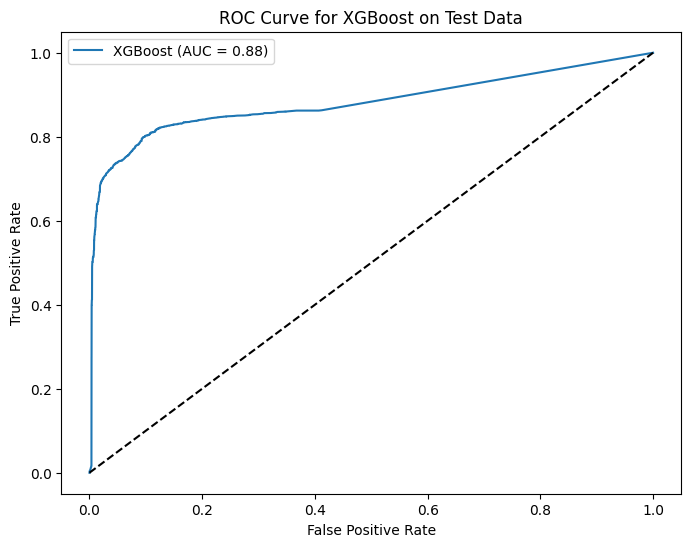

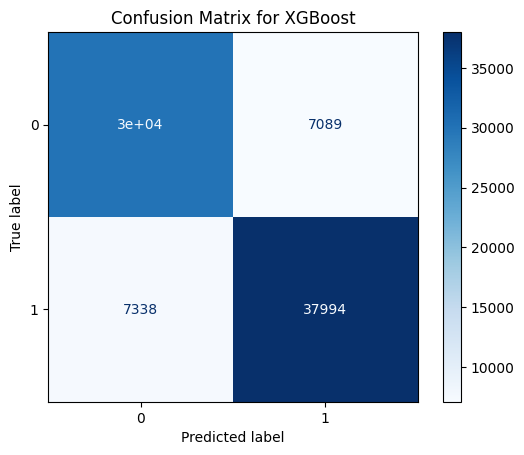

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_test = final_clf.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()
